# <CENTER>TASK 2<br>Experimentation and uplift testing

In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.offline as offline
offline.init_notebook_mode()
import cufflinks as cf
cf.go_offline()

In [4]:
#reading data
data=pd.read_csv("QVI_data.csv");
data.head(2)

LYLTY_CARD_NBR        DATE  STORE_NBR  TXN_ID  PROD_NBR  \
0            1000  2018-10-17          1       1         5   
1            1002  2018-09-16          1       2        58   

                                PROD_NAME  PROD_QTY  TOT_SALES  PACK_SIZE  \
0  Natural Chip        Compny SeaSalt175g         2        6.0        175   
1   Red Rock Deli Chikn&Garlic Aioli 150g         1        2.7        150   

     BRAND              LIFESTAGE PREMIUM_CUSTOMER  
0  NATURAL  YOUNG SINGLES/COUPLES          Premium  
1      RRD  YOUNG SINGLES/COUPLES       Mainstream

In [5]:
data['DATE']=pd.to_datetime(data['DATE'])

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   LYLTY_CARD_NBR    264834 non-null  int64         
 1   DATE              264834 non-null  datetime64[ns]
 2   STORE_NBR         264834 non-null  int64         
 3   TXN_ID            264834 non-null  int64         
 4   PROD_NBR          264834 non-null  int64         
 5   PROD_NAME         264834 non-null  object        
 6   PROD_QTY          264834 non-null  int64         
 7   TOT_SALES         264834 non-null  float64       
 8   PACK_SIZE         264834 non-null  int64         
 9   BRAND             264834 non-null  object        
 10  LIFESTAGE         264834 non-null  object        
 11  PREMIUM_CUSTOMER  264834 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(6), object(4)
memory usage: 24.2+ MB


In [7]:
data['YEARMONTH']=[s.year*100+s.month for s in data['DATE']]

In [8]:
data

LYLTY_CARD_NBR       DATE  STORE_NBR  TXN_ID  PROD_NBR  \
0                 1000 2018-10-17          1       1         5   
1                 1002 2018-09-16          1       2        58   
2                 1003 2019-03-07          1       3        52   
3                 1003 2019-03-08          1       4       106   
4                 1004 2018-11-02          1       5        96   
...                ...        ...        ...     ...       ...   
264829         2370701 2018-12-08         88  240378        24   
264830         2370751 2018-10-01         88  240394        60   
264831         2370961 2018-10-24         88  240480        70   
264832         2370961 2018-10-27         88  240481        65   
264833         2373711 2018-12-14         88  241815        16   

                                       PROD_NAME  PROD_QTY  TOT_SALES  \
0         Natural Chip        Compny SeaSalt175g         2        6.0   
1          Red Rock Deli Chikn&Garlic Aioli 150g         1        2.7   
2          Grain Waves Sour    Cream&Chives 210G         1        3.6   
3         Natural ChipCo      Hony Soy Chckn175g         1        3.0   
4                 WW Original Stacked Chips 160g         1        1.9   
...                                          ...       ...        ...   
264829     Grain Waves         Sweet Chilli 210g         2        7.2   
264830      Kettle Tortilla ChpsFeta&Garlic 150g         2        9.2   
264831   Tyrrells Crisps     Lightly Salted 165g         2        8.4   
264832  Old El Paso Salsa   Dip Chnky Tom Ht300g         2       10.2   
264833  Smiths Crinkle Chips Salt & Vinegar 330g         2       11.4   

        PACK_SIZE       BRAND              LIFESTAGE PREMIUM_CUSTOMER  \
0             175     NATURAL  YOUNG SINGLES/COUPLES          Premium   
1             150         RRD  YOUNG SINGLES/COUPLES       Mainstream   
2             210     GRNWVES         YOUNG FAMILIES           Budget   
3             175     NATURAL         YOUNG FAMILIES           Budget   
4             160  WOOLWORTHS  OLDER SINGLES/COUPLES       Mainstream   
...           ...         ...                    ...              ...   
264829        210     GRNWVES         YOUNG FAMILIES       Mainstream   
264830        150      KETTLE         YOUNG FAMILIES          Premium   
264831        165    TYRRELLS         OLDER FAMILIES           Budget   
264832        300         OLD         OLDER FAMILIES           Budget   
264833        330      SMITHS  YOUNG SINGLES/COUPLES       Mainstream   

        YEARMONTH  
0          201810  
1          201809  
2          201903  
3          201903  
4          201811  
...           ...  
264829     201812  
264830     201810  
264831     201810  
264832     201810  
264833     201812  

[264834 rows x 13 columns]

### METRICS UNDER CONSIDERATION:
#### - Monthly overall sales revenue
#### - Monthly number of customers
#### - Monthly number of transactions per customer

In [9]:
metrics=data.groupby(['STORE_NBR','YEARMONTH']).agg({'TOT_SALES':'sum','LYLTY_CARD_NBR':'nunique','TXN_ID':'nunique','PROD_QTY':'sum'})
metrics['PRICE_PER_UNIT']=metrics['TOT_SALES']/metrics['PROD_QTY']
metrics['CHIP_PER_TXN']=metrics['PROD_QTY']/metrics['TXN_ID']
metrics=metrics.rename(columns={'LYLTY_CARD_NBR':'CUSTOMERS'})
metrics['TXN_PER_CUST']=metrics['TXN_ID']/metrics['CUSTOMERS']
metrics.drop(['TXN_ID'],axis=1,inplace=True)

In [10]:
full=metrics.copy()

In [11]:
#taking data before 2019-02 into consideration
trial=[]
for i in metrics.index:
    if(i[1]>=201902):
        if(i[1]<=201904):
            trial.append(metrics.loc[i])
        metrics.drop(i,inplace=True)
trial=pd.DataFrame(trial)

In [12]:
#taking data after 2019-02 into trial dataframe
trial.index.name=('IDX')
k=0
trial['STORE_NBR']=0
trial['MONTHYEAR']=0
for (i,j) in trial.reset_index()['IDX']:
    trial['STORE_NBR'].iloc[k]=i
    trial['MONTHYEAR'][k]=j 
    k=k+1
trial=trial.set_index(['STORE_NBR','MONTHYEAR'])

KeyError: 'IDX'

In [ ]:
metrics

### Funtions to find correlation and magnitude of any store wih another store

In [13]:
def calcCorr(store):
    '''
    input=store number which is to be compared
    output=dataframe with corelation coefficient values
    '''
    a=[]
    metrix=metrics[['TOT_SALES','CUSTOMERS']]#add metrics as required e.g. ,'TXN_PER_CUST'
    for i in metrix.index:
        a.append(metrix.loc[store].corrwith(metrix.loc[i[0]]))
    df= pd.DataFrame(a)
    df.index=metrix.index
    df=df.drop_duplicates()
    df.index=[s[0] for s in df.index]
    df.index.name="STORE_NBR"
    return df

In [14]:
def standardizer(df):
    '''
    input=dataframe with metrics
    output=dataframe with mean of the metrics in a new column
    '''
    df=df.abs()
    df['MAGNITUDE']=df.mean(axis=1)
    return df

***

### Store 77
Finding stores corelated to store 77

In [15]:
corr77=calcCorr(77)

In [16]:
corr77.head(3)

TOT_SALES  CUSTOMERS
STORE_NBR                      
1           0.075218   0.322168
2          -0.263079  -0.572051
3           0.806644   0.834207

In [17]:
corr77=standardizer(corr77)
corr77

TOT_SALES  CUSTOMERS  MAGNITUDE
STORE_NBR                                 
1           0.075218   0.322168   0.198693
2           0.263079   0.572051   0.417565
3           0.806644   0.834207   0.820426
4           0.263300   0.295639   0.279469
5           0.110652   0.370659   0.240655
...              ...        ...        ...
268         0.344757   0.369517   0.357137
269         0.315730   0.474293   0.395011
270         0.315430   0.131259   0.223345
271         0.355487   0.019629   0.187558
272         0.117622   0.223217   0.170420

[266 rows x 3 columns]

In [18]:
corr77=corr77.sort_values(['MAGNITUDE'],ascending=False).dropna()

In [19]:
corr77

TOT_SALES  CUSTOMERS  MAGNITUDE
STORE_NBR                                 
77          1.000000   1.000000   1.000000
233         0.903774   0.990358   0.947066
119         0.867664   0.983267   0.925466
71          0.914106   0.754817   0.834461
3           0.806644   0.834207   0.820426
...              ...        ...        ...
256         0.014245   0.047863   0.031054
159         0.001655   0.054404   0.028030
260         0.016618   0.027446   0.022032
194         0.010182   0.032053   0.021117
166         0.005875   0.012896   0.009386

[263 rows x 3 columns]

#### **shows that stores 233,119,71 are the most correlated to store 77

### Selecting 233 as control store as it has  max correlation

## Visualizing ...

<Axes: xlabel='STORE_NBR'>

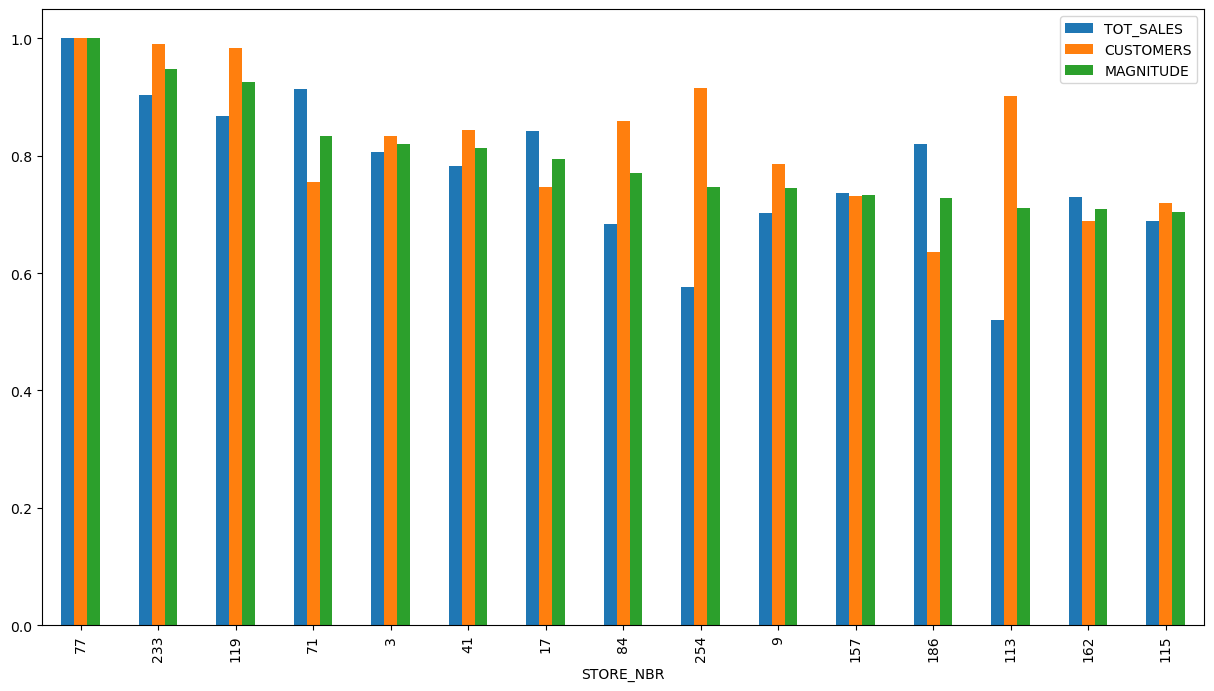

In [20]:
#Taking 0.7 as threshold corelation
corr77[(corr77.MAGNITUDE.abs()>0.7)].plot(kind='bar',figsize=(15,8))

<Axes: ylabel='STORE_NBR'>

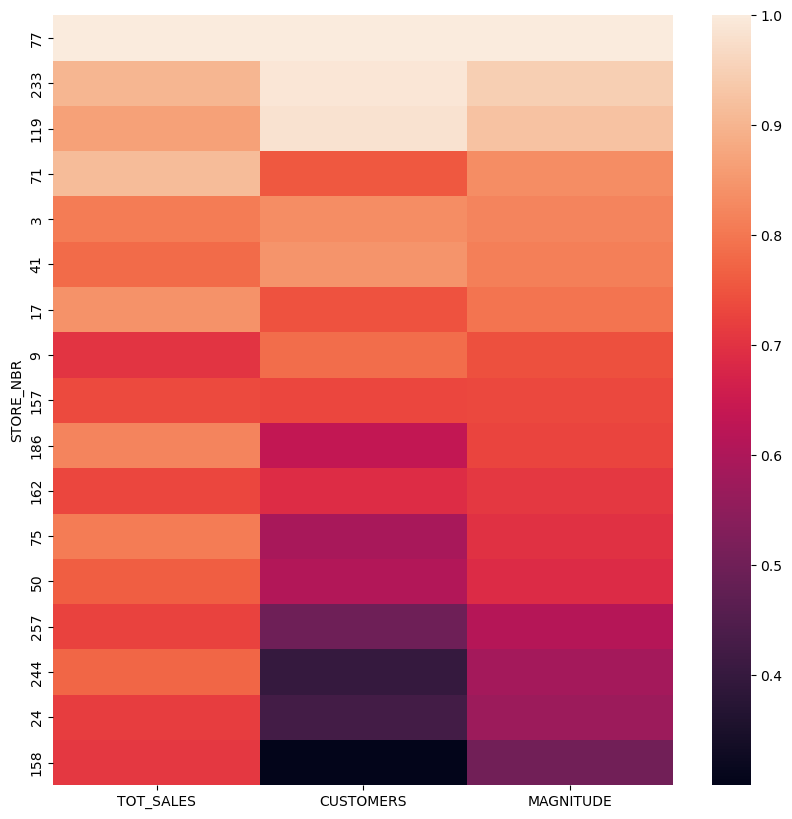

In [21]:
plt.figure(figsize=(10,10))
sns.heatmap(corr77[corr77.TOT_SALES.abs()>0.7])

#### Taking the store 233 into consideration plotting different measure against those of store 77

C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\3418971422.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\3418971422.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




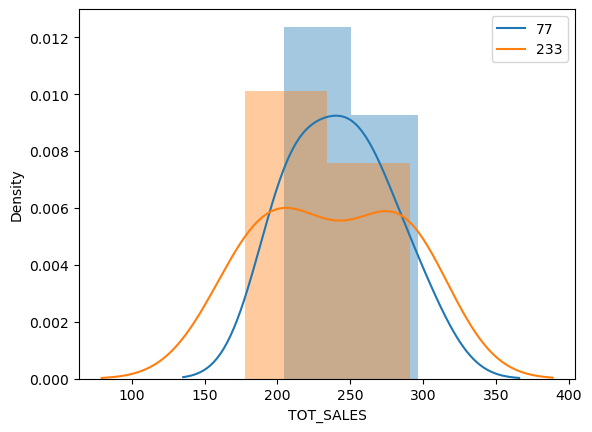

In [22]:
sns.distplot(metrics.loc[77]['TOT_SALES'])
sns.distplot(metrics.loc[233]['TOT_SALES'])
plt.legend(labels=['77','233'])

C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\512825119.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\512825119.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




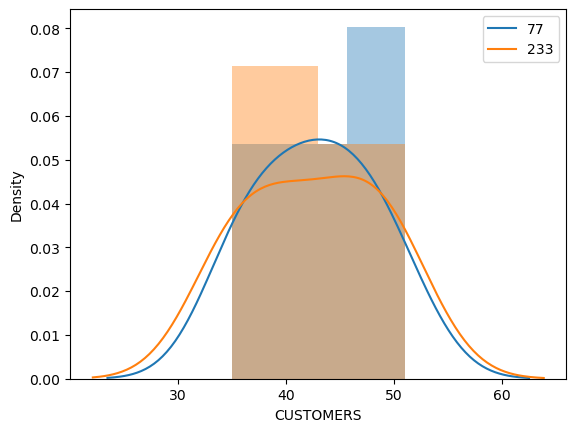

In [23]:
sns.distplot(metrics.loc[77]['CUSTOMERS'])
sns.distplot(metrics.loc[233]['CUSTOMERS'])
plt.legend(labels=['77','233'])

C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\3594496371.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\3594496371.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




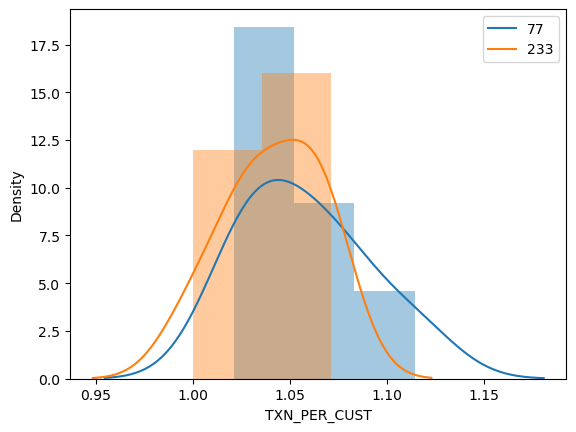

In [24]:
sns.distplot(metrics.loc[77]['TXN_PER_CUST'])
sns.distplot(metrics.loc[233]['TXN_PER_CUST'])
plt.legend(labels=['77','233'])

### Since distributions of store 233 are similar to that of store 77, selecting store 233 as control store with max similarities to store 77

## Calculating difference between scaled control sales and trial sales
Let null hypothesis be that both stores 77 ans 233 have no difference

In [25]:
from scipy.stats import ks_2samp,ttest_ind,t

In [74]:
# difference between control and trial sales
a=[]
for x in metrics.columns:
    a.append(ks_2samp(metrics.loc[77][x], metrics.loc[233][x]))
a=pd.DataFrame(a,index=metrics.columns)

C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\2371473180.py:4: RuntimeWarning:

ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.



In [75]:
a

statistic    pvalue
TOT_SALES        0.285714  0.962704
CUSTOMERS        0.142857  0.999961
PROD_QTY         0.285714  0.962704
PRICE_PER_UNIT   0.285714  0.962704
CHIP_PER_TXN     0.285714  0.962704
TXN_PER_CUST     0.428571  0.575175

In [76]:
from scipy.stats import ttest_ind
b = []

for x in trial.columns:
    b.append(ttest_ind(trial.loc[77][x].tail(2), trial.loc[233][x].tail(2)))
b_df = pd.DataFrame(b, index=trial.columns)

In [77]:
b

[TtestResult(statistic=4.267335718552558, pvalue=0.05076881409465864, df=2.0),
 TtestResult(statistic=2.5861309700971087, pvalue=0.12261789030076836, df=2.0),
 TtestResult(statistic=4.043680421515942, pvalue=0.05606345536654277, df=2.0),
 TtestResult(statistic=-0.6341732526845992, pvalue=0.5908283504129962, df=2.0),
 TtestResult(statistic=1.7851264851986517, pvalue=0.21616543644909403, df=2.0),
 TtestResult(statistic=0.33243393574435853, pvalue=0.7711708194767704, df=2.0),
 TtestResult(statistic=nan, pvalue=nan, df=2.0),
 TtestResult(statistic=nan, pvalue=nan, df=2.0)]

In [29]:
#critical value
t.ppf(0.95,df=7)

1.894578605061305

Since all of the p-values are high (say more than 0.05), we reject the null hypothesis i.e. there means are significantly different.<br>
We can observe that the t-value is much larger than the 95th percentile value of
the t-distribution for March and April - i.e. the increase in sales in the trial
store in March and April is statistically greater than in the control store.

#### Vizualizing means

C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\3423653171.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\3423653171.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




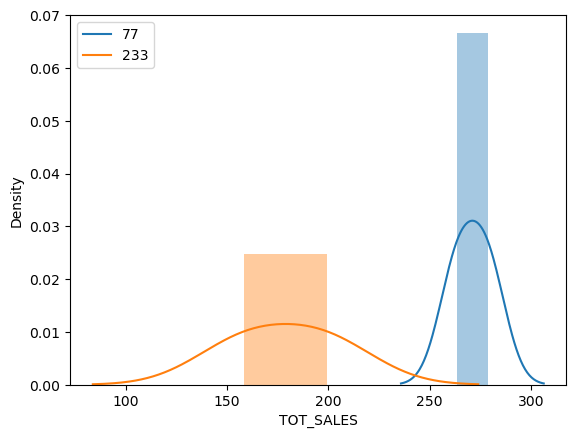

In [30]:
sns.distplot(trial.loc[77]['TOT_SALES'].tail(2))
sns.distplot(trial.loc[233]['TOT_SALES'].tail(2))
plt.legend(labels=['77','233'])

C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\1483174075.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\1483174075.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




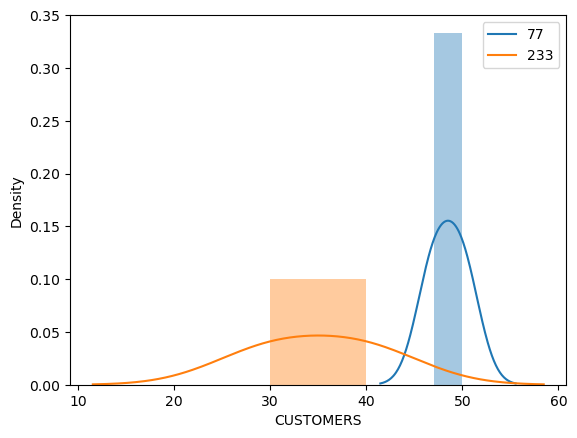

In [31]:
sns.distplot(trial.loc[77]['CUSTOMERS'].tail(2))
sns.distplot(trial.loc[233]['CUSTOMERS'].tail(2))
plt.legend(labels=['77','233'])

#### It can be visualized that the is a significant difference in the means, so trial store behavior(77) is different from control store (233).<br>
The results show that the trial in store 77 is significantly different to its
control store in the trial period as the trial store performance lies outside the
5% to 95% confidence interval of the control store in two of the three trial
months.


***

### Store 86
Repeating same process for trial store 86

In [32]:
corr86=calcCorr(86)

In [33]:
corr86.head(3)

TOT_SALES  CUSTOMERS
STORE_NBR                      
1           0.445632   0.485831
2          -0.403835  -0.086161
3          -0.261284  -0.353786

In [34]:
corr86=standardizer(corr86)
corr86

TOT_SALES  CUSTOMERS  MAGNITUDE
STORE_NBR                                 
1           0.445632   0.485831   0.465731
2           0.403835   0.086161   0.244998
3           0.261284   0.353786   0.307535
4           0.039035   0.169608   0.104322
5           0.235159   0.253229   0.244194
...              ...        ...        ...
268         0.452182   0.034273   0.243228
269         0.697055   0.098587   0.397821
270         0.730679   0.767267   0.748973
271         0.527637   0.267393   0.397515
272         0.004926   0.353815   0.179371

[266 rows x 3 columns]

In [35]:
corr86=corr86.sort_values(['MAGNITUDE'],ascending=False).dropna()

In [36]:
corr86

TOT_SALES  CUSTOMERS  MAGNITUDE
STORE_NBR                                 
86          1.000000   1.000000   1.000000
155         0.877882   0.942876   0.910379
23          0.784698   0.943559   0.864128
120         0.872693   0.815097   0.843895
114         0.734415   0.855339   0.794877
...              ...        ...        ...
91          0.019027   0.041271   0.030149
17          0.029793   0.030039   0.029916
131         0.028487   0.031142   0.029815
219         0.046653   0.004999   0.025826
234         0.010509   0.040306   0.025407

[263 rows x 3 columns]

#### **shows that stores 155,23,120 are the most correlated to store 86

### Selecting 155 as control store as it has  max correlation

## Visualizing ...

<Axes: xlabel='STORE_NBR'>

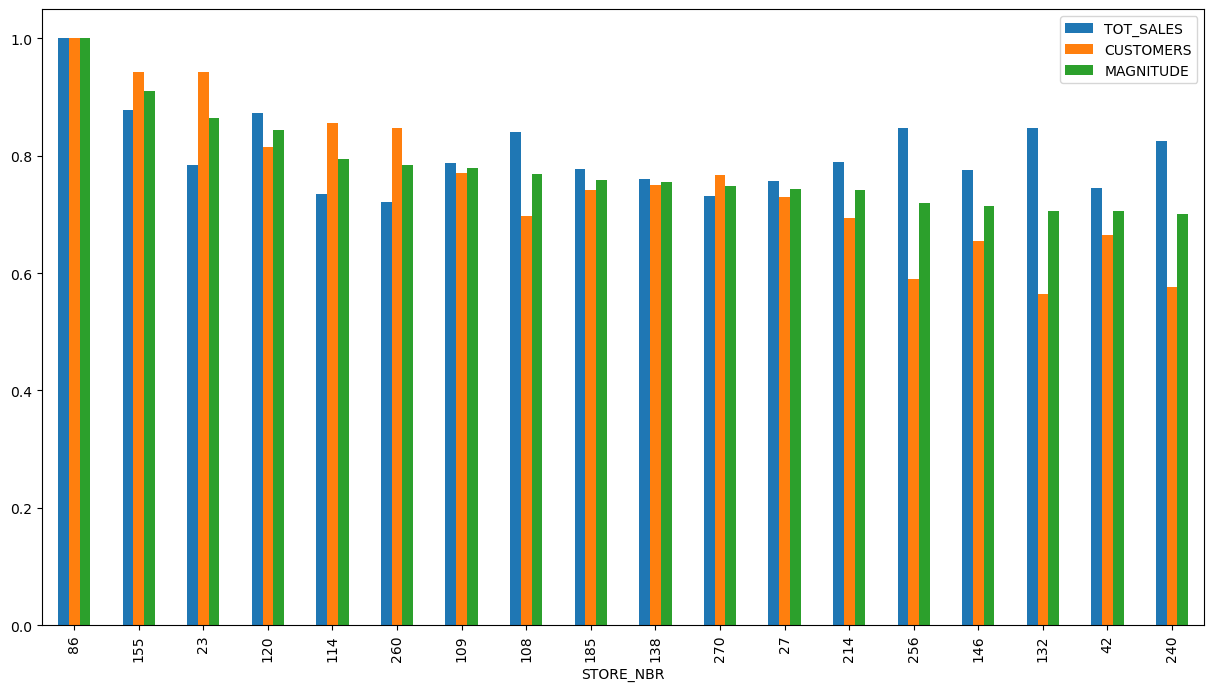

In [37]:
#Taking 0.7 as threshold corelation
corr86[(corr86.MAGNITUDE.abs()>0.7)].plot(kind='bar',figsize=(15,8))

<Axes: ylabel='STORE_NBR'>

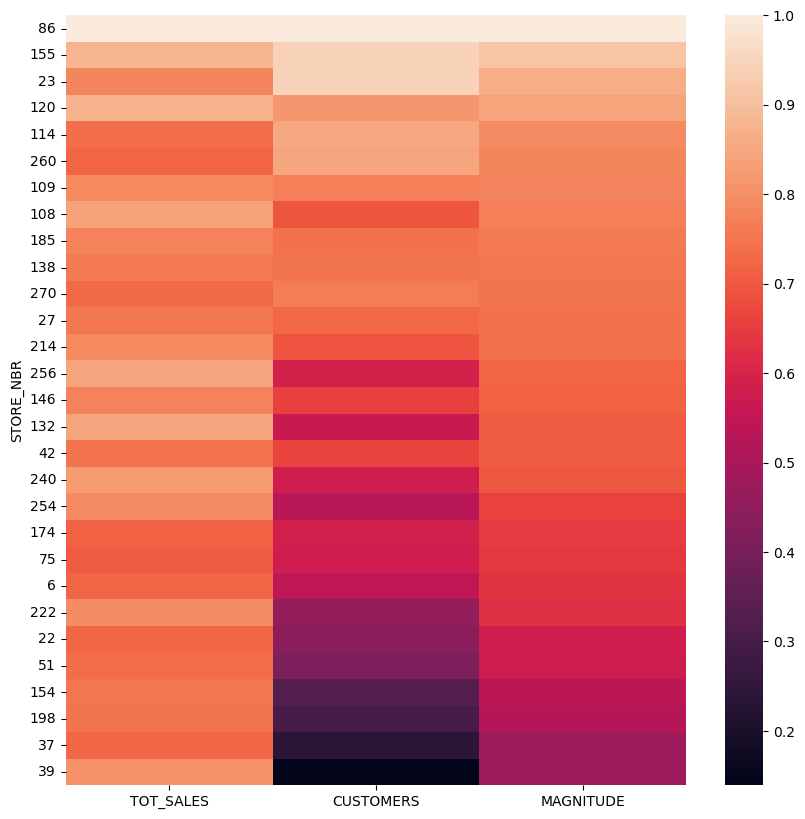

In [38]:
plt.figure(figsize=(10,10))
sns.heatmap(corr86[corr86.TOT_SALES.abs()>0.7])

#### Taking the store 155 into consideration plotting different measure against those of store 86

C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\1112463217.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\1112463217.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




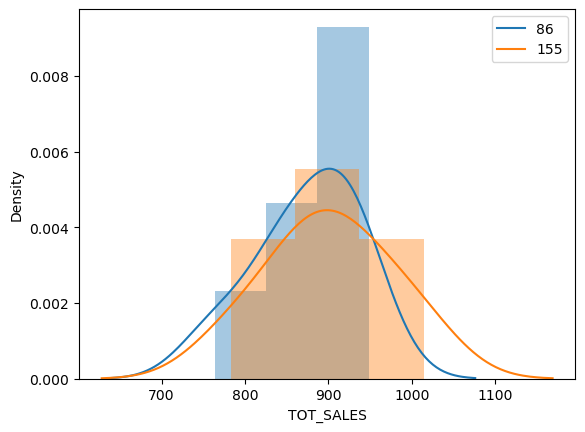

In [39]:
sns.distplot(metrics.loc[86]['TOT_SALES'])
sns.distplot(metrics.loc[155]['TOT_SALES'])
plt.legend(labels=['86','155'])

C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\938361569.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\938361569.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




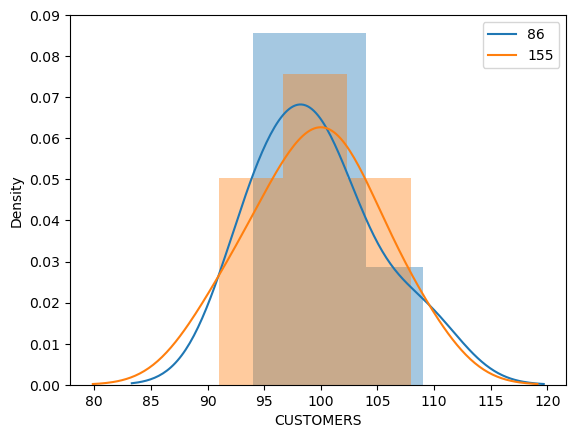

In [40]:
sns.distplot(metrics.loc[86]['CUSTOMERS'])
sns.distplot(metrics.loc[155]['CUSTOMERS'])
plt.legend(labels=['86','155'])

C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\999707.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\999707.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




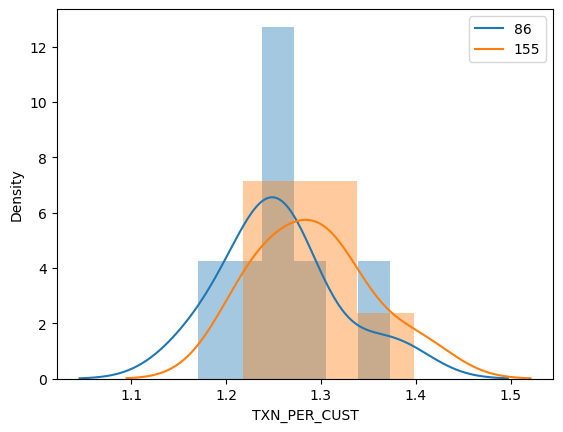

In [41]:
sns.distplot(metrics.loc[86]['TXN_PER_CUST'])
sns.distplot(metrics.loc[155]['TXN_PER_CUST'])
plt.legend(labels=['86','155'])

C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\1871391030.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\1871391030.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




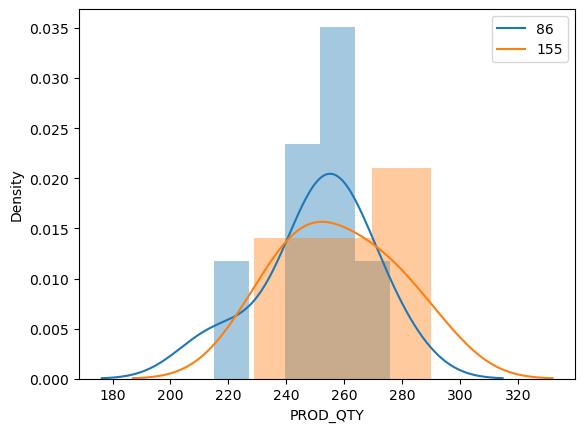

In [42]:
sns.distplot(metrics.loc[86]['PROD_QTY'])
sns.distplot(metrics.loc[155]['PROD_QTY'])
plt.legend(labels=['86','155'])

### Since distributions of store 155 are similar to that of store 86, selecting store 155 as control store with max similarities to store 86

## Calculating difference between scaled control sales and trial sales
Let null hypothesis be that both stores 77 ans 233 have no difference

In [43]:
from scipy.stats import ks_2samp,ttest_ind,ttest_rel,t

In [44]:
# difference between control and trial sales
a=[]
for x in metrics.columns:
    a.append(ks_2samp(metrics.loc[86][x], metrics.loc[155][x]))
a=pd.DataFrame(a,index=metrics.columns)

In [45]:
a

statistic    pvalue
TOT_SALES        0.285714  0.962704
CUSTOMERS        0.285714  0.962704
PROD_QTY         0.285714  0.962704
PRICE_PER_UNIT   0.428571  0.575175
CHIP_PER_TXN     0.428571  0.575175
TXN_PER_CUST     0.428571  0.575175

#### For pre trial period, since p-values for TOT_SALES, CUSTOMERS and PROD_QTY are high (say more than 0.95), we can't reject the null hypothesis
## Assessment of trial
The trial period goes from the start of February 2019 to April 2019. We now want to
see if there has been an uplift in overall chip sales. 


In [73]:
b = []

for x in trial.columns:
    b.append(ttest_ind(trial.loc[86][x].tail(2), trial.loc[155][x].tail(2)))
b_df = pd.DataFrame(b, index=trial.columns)

In [48]:
b

[TtestResult(statistic=1.234511973459806, pvalue=0.3423782995617056, df=2.0),
 TtestResult(statistic=2.414953415699773, pvalue=0.1370762576641993, df=2.0),
 TtestResult(statistic=1.8625322946656702, pvalue=0.2035678264159959, df=2.0),
 TtestResult(statistic=0.3662137805590835, pvalue=0.749316341306336, df=2.0),
 TtestResult(statistic=-0.2859375734541281, pvalue=0.8018218058538022, df=2.0),
 TtestResult(statistic=-1.074766842347899, pvalue=0.39492938851613935, df=2.0),
 TtestResult(statistic=nan, pvalue=nan, df=2.0),
 TtestResult(statistic=nan, pvalue=nan, df=2.0)]

In [49]:
#critical value
t.ppf(0.95,df=7)

1.894578605061305

Since all of the p-values are high (say more than 0.05), we reject the null hypothesis i.e. there means are significantly different.<br>
We can observe that the t-value is much larger than the 95th percentile value of
the t-distribution for March and April - i.e. the increase in sales in the trial
store in March and April is statistically greater than in the control store.

The results show that the trial in store 88 is significantly different to its
control store in the trial period as the trial store performance lies outside of
the 5% to 95% confidence interval of the control store in two of the three trial
months.

#### Vizualizing means

C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\495834011.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\495834011.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




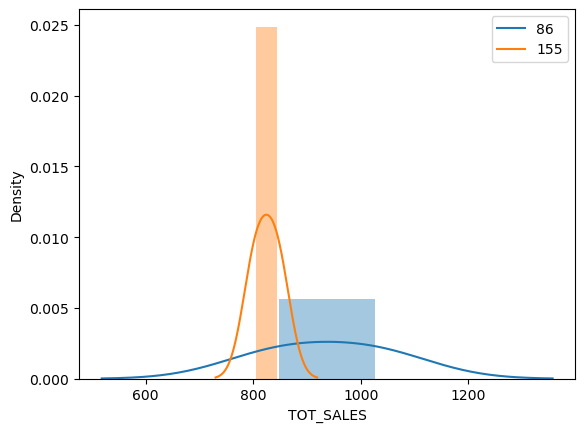

In [50]:
sns.distplot(trial.loc[86]['TOT_SALES'].tail(2))
sns.distplot(trial.loc[155]['TOT_SALES'].tail(2))
plt.legend(labels=['86','155'])

C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\3682141979.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\3682141979.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




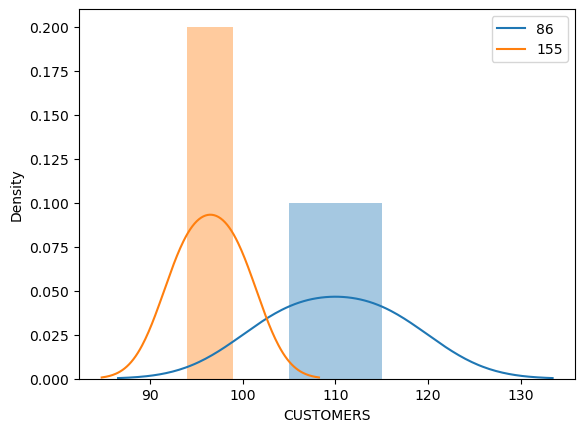

In [51]:
sns.distplot(trial.loc[86]['CUSTOMERS'].tail(2))
sns.distplot(trial.loc[155]['CUSTOMERS'].tail(2))
plt.legend(labels=['86','155'])

#### It can be visualized that the is a significant difference in the means, so trial store behavior(86) is different from control store (155).<br>
It looks like the number of customers is significantly higher in all of the three months. This seems to suggest that the trial had a significant impact on increasingthe number of customers in trial store 86 but as we saw, sales were not significantly higher. We should check with the Category Manager if there were special deals in the trial store that were may have resulted in lower prices, impacting the results.

***

## Store 88
Finding stores corelated to store 88

In [52]:
corr88=calcCorr(88)

In [53]:
corr88.head(3)

TOT_SALES  CUSTOMERS
STORE_NBR                      
1           0.813636   0.305334
2          -0.067927  -0.452379
3          -0.507847   0.522884

In [54]:
corr88=standardizer(corr88)
corr88

TOT_SALES  CUSTOMERS  MAGNITUDE
STORE_NBR                                 
1           0.813636   0.305334   0.559485
2           0.067927   0.452379   0.260153
3           0.507847   0.522884   0.515365
4           0.745566   0.361503   0.553534
5           0.190330   0.025320   0.107825
...              ...        ...        ...
268         0.021429   0.672672   0.347050
269         0.172578   0.274781   0.223679
270         0.723272   0.103032   0.413152
271         0.103037   0.018831   0.060934
272         0.772772   0.026909   0.399841

[265 rows x 3 columns]

In [55]:
corr88=corr88.sort_values(['MAGNITUDE'],ascending=False).dropna()

In [56]:
corr88.head(15)

TOT_SALES  CUSTOMERS  MAGNITUDE
STORE_NBR                                 
88          1.000000   1.000000   1.000000
178         0.731857   0.939466   0.835661
14          0.698557   0.942976   0.820767
133         0.735407   0.835426   0.785417
204         0.885774   0.550263   0.718018
134         0.864293   0.508880   0.686587
113         0.495763   0.862632   0.679198
253         0.811838   0.500962   0.656400
239         0.642329   0.660672   0.651501
230         0.908883   0.373350   0.641117
187         0.599076   0.671264   0.635170
227         0.537448   0.729943   0.633695
69          0.450029   0.815792   0.632910
237         0.308479   0.947326   0.627903
141         0.690590   0.547399   0.618994

#### **shows that stores 178,14,133 are the most correlated to store 88

## Visualizing ...

<Axes: xlabel='STORE_NBR'>

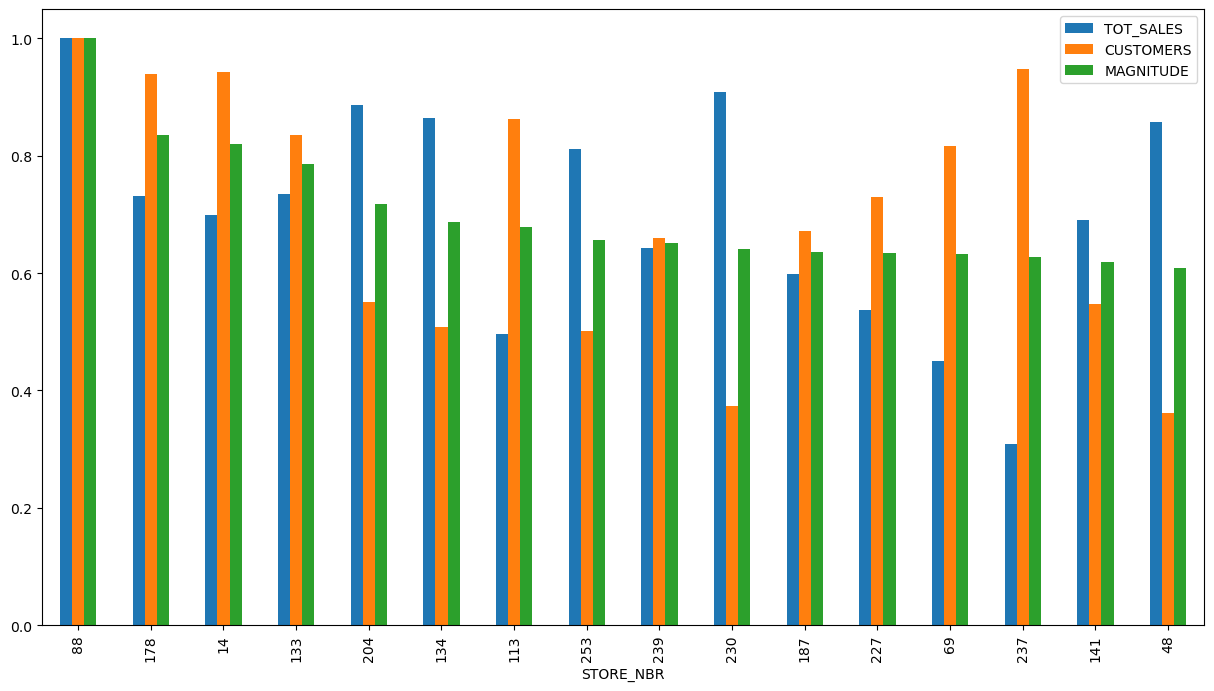

In [57]:
#Taking 0.6 as threshold corelation
corr88[(corr88.MAGNITUDE.abs()>0.6)].plot(kind='bar',figsize=(15,8))

<Axes: ylabel='STORE_NBR'>

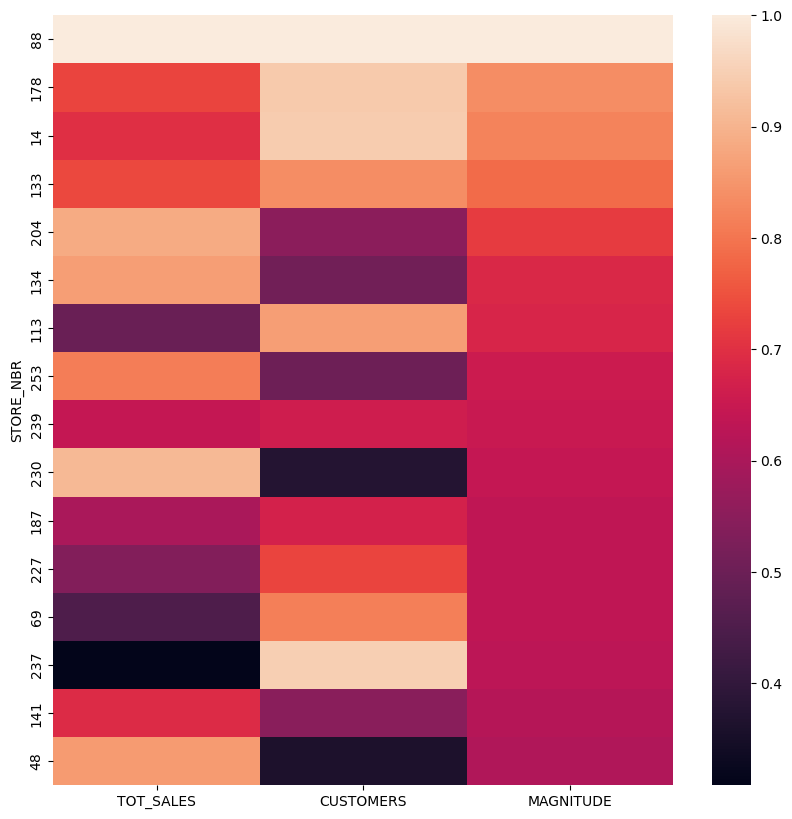

In [58]:
plt.figure(figsize=(10,10))
sns.heatmap(corr88[corr88.MAGNITUDE.abs()>0.6])

C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\3816158040.py:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\3816158040.py:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\3816158040.py:3: UserWarning:



`distpl

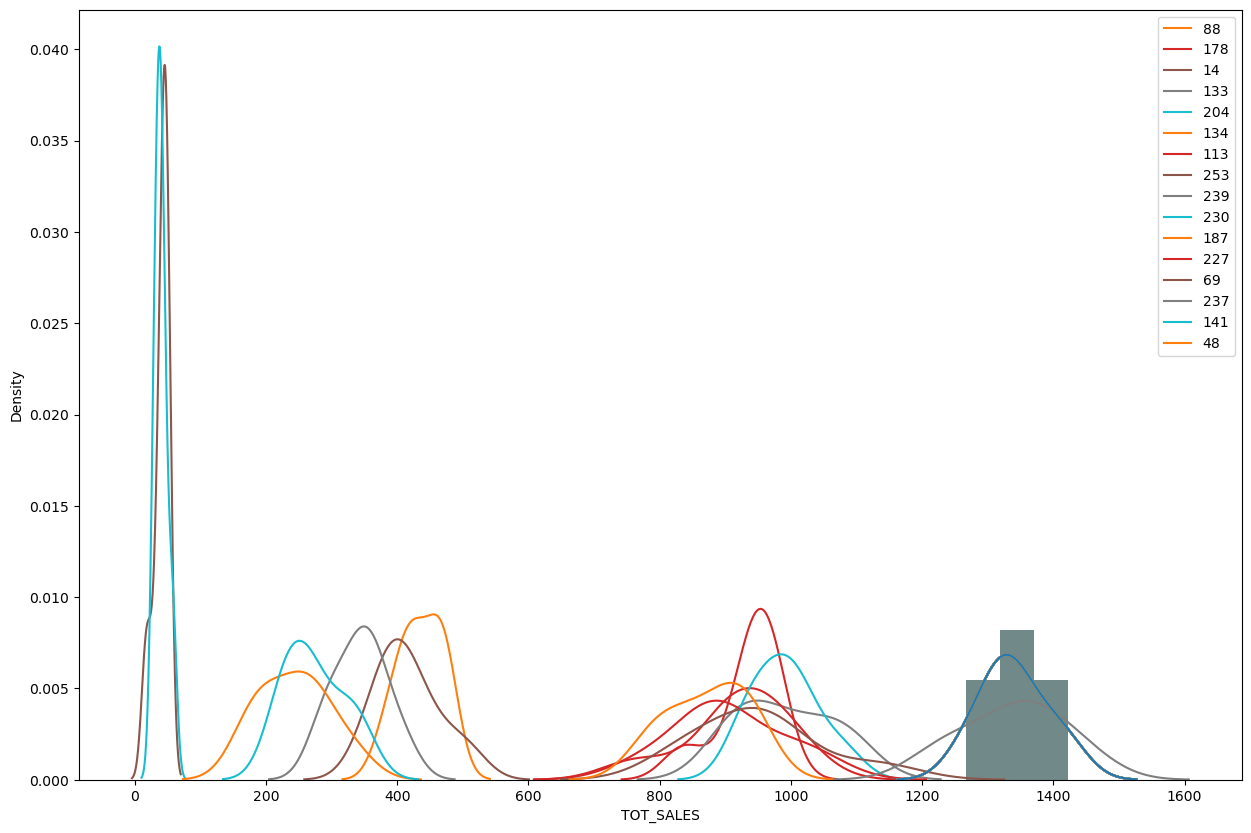

In [59]:
plt.figure(figsize=(15,10))
for x in corr88[corr88.MAGNITUDE.abs()>0.6].index:
    sns.distplot(metrics.loc[88]['TOT_SALES'])
    sns.distplot(metrics.loc[x]['TOT_SALES'],label=x,hist=False)
plt.legend()

#### Therefore Taking the store 237 into consideration plotting different measure against those of store 88

C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\2629689805.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\2629689805.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




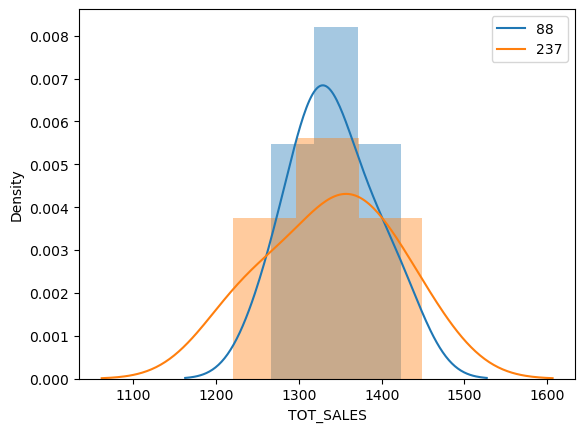

In [60]:
sns.distplot(metrics.loc[88]['TOT_SALES'])
sns.distplot(metrics.loc[237]['TOT_SALES'])
plt.legend(labels=['88','237'])

C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\132821773.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\132821773.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




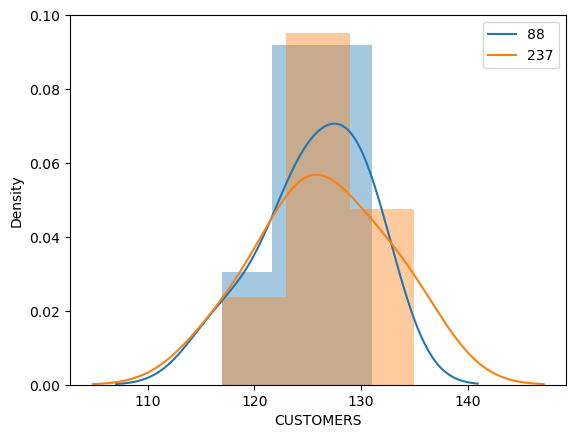

In [61]:
sns.distplot(metrics.loc[88]['CUSTOMERS'])
sns.distplot(metrics.loc[237]['CUSTOMERS'])
plt.legend(labels=['88','237'])

C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\3550943983.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\3550943983.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




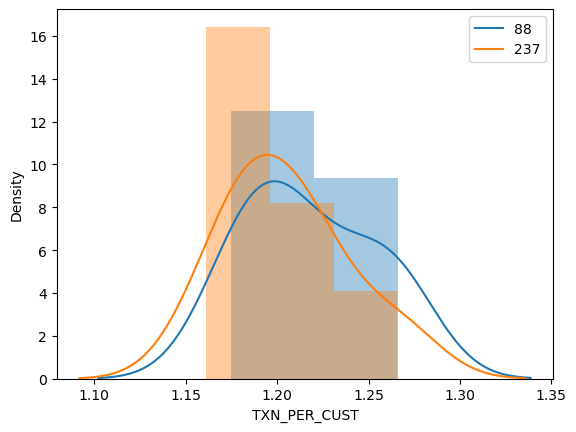

In [62]:
sns.distplot(metrics.loc[88]['TXN_PER_CUST'])
sns.distplot(metrics.loc[237]['TXN_PER_CUST'])
plt.legend(labels=['88','237'])

### Since distributions of store 237 are similar to that of store 88, selecting store 237 as control store with max similarities to store 88

## Calculating difference between scaled control sales and trial sales
Let null hypothesis be that both stores 88 ans 237 have no difference

In [63]:
from scipy.stats import ks_2samp,ttest_ind,t

In [64]:
# difference between control and trial sales
a=[]
for x in metrics.columns:
    a.append(ks_2samp(metrics.loc[88][x], metrics.loc[237][x]))
a=pd.DataFrame(a,index=metrics.columns)

In [65]:
a

statistic    pvalue
TOT_SALES        0.285714  0.962704
CUSTOMERS        0.285714  0.962704
PROD_QTY         0.285714  0.962704
PRICE_PER_UNIT   0.428571  0.575175
CHIP_PER_TXN     0.571429  0.212121
TXN_PER_CUST     0.285714  0.962704

#### For pre trial period, since all of the p-values are high (say more than 0.05), we can't reject the null hypothesis
## Assessment of trial
The trial period goes from the start of February 2019 to April 2019. We now want to
see if there has been an uplift in overall chip sales. 


Sampling march and april from the 3 months

In [67]:
b = []

for x in trial.columns:
    b.append(ttest_ind(trial.loc[86][x].tail(2), trial.loc[237][x].tail(2)))
b_df = pd.DataFrame(b, index=trial.columns)

In [68]:
b

[TtestResult(statistic=-3.0105866763736415, pvalue=0.09488810647697474, df=2.0),
 TtestResult(statistic=-1.8905706613989794, pvalue=0.19924547127392972, df=2.0),
 TtestResult(statistic=-0.2660760420950957, pvalue=0.8150999345915904, df=2.0),
 TtestResult(statistic=-6.804115475482312, pvalue=0.02092457277413807, df=2.0),
 TtestResult(statistic=-0.4654558371553213, pvalue=0.6873704661554735, df=2.0),
 TtestResult(statistic=9.547202317372427, pvalue=0.010793732324144467, df=2.0),
 TtestResult(statistic=nan, pvalue=nan, df=2.0),
 TtestResult(statistic=nan, pvalue=nan, df=2.0)]

In [69]:
#critical value
t.ppf(0.95,df=7)

1.894578605061305

Since all of the p-values are high (say more than 0.05), we reject the null hypothesis i.e. there means are significantly different.<br>

The results show that the trial in store 88 is significantly different to its
control store in the trial period as the trial store performance lies outside of
the 5% to 95% confidence interval of the control store in two of the three trial
months.

#### Vizualizing means

C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\3345218753.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\3345218753.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




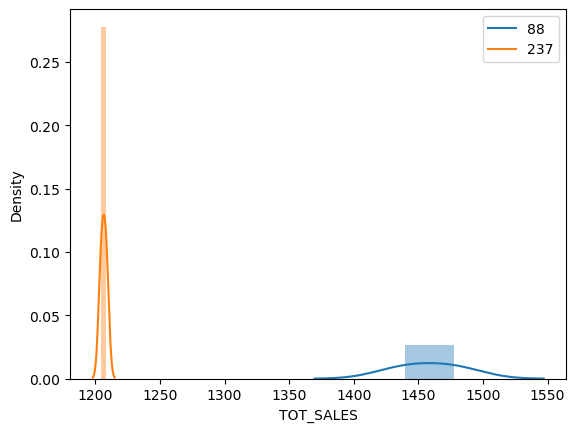

In [70]:
sns.distplot(trial.loc[88]['TOT_SALES'].tail(2))
sns.distplot(trial.loc[237]['TOT_SALES'].tail(2))
plt.legend(labels=['88','237'])

C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\1775249445.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\Vikra\AppData\Local\Temp\ipykernel_7728\1775249445.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




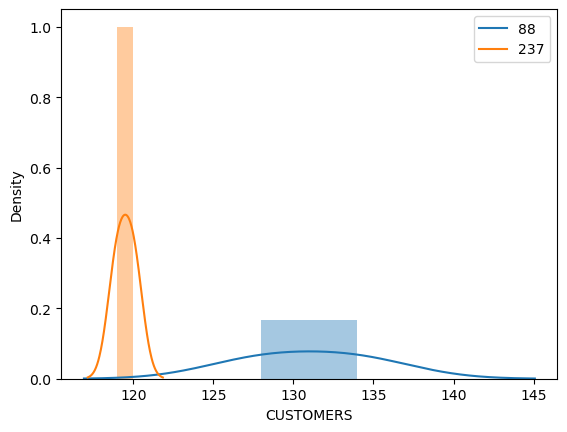

In [71]:
sns.distplot(trial.loc[88]['CUSTOMERS'].tail(2))
sns.distplot(trial.loc[237]['CUSTOMERS'].tail(2))
plt.legend(labels=['88','237'])

#### It can be visualized that the is a significant difference in the means, so trial store behavior(88) is different from control store (237).<br>
Total number of customers in the trial period for the trial store is significantly
higher than the control store for two out of three months, which indicates a
positive trial effect.




***

(201901.0, 201906.0)

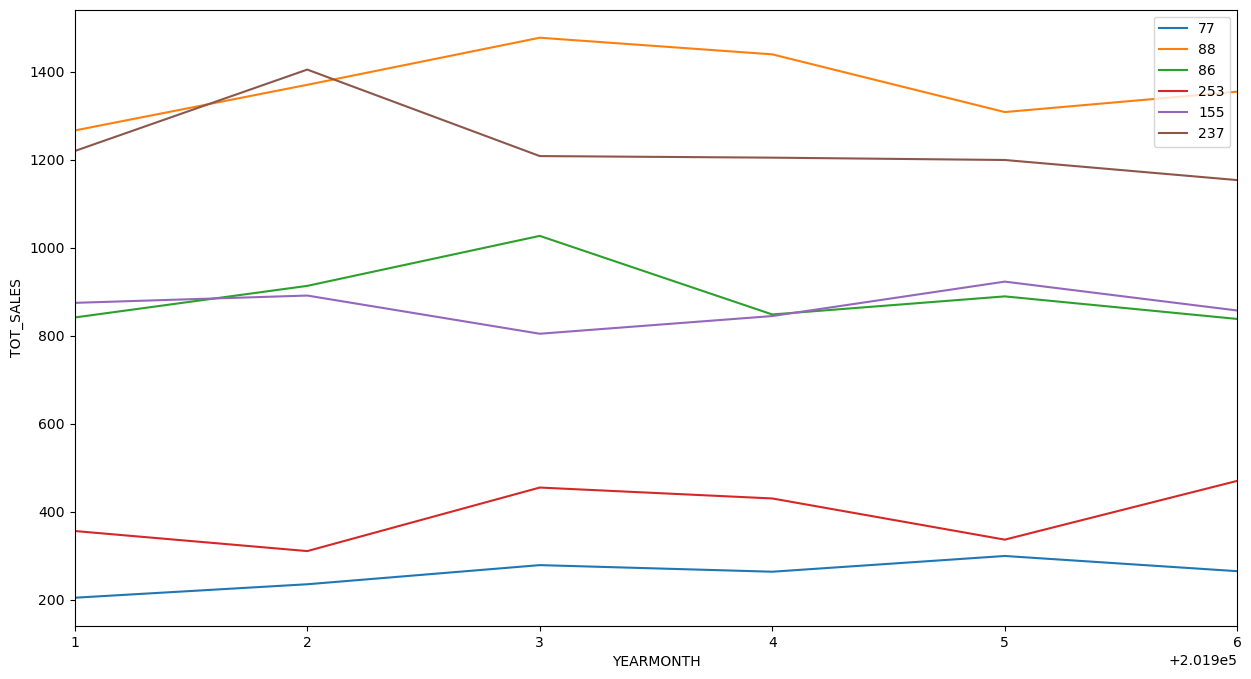

In [72]:
fig, ax = plt.subplots(figsize=(15, 8))
x=['77','88','86','253','155','237']
for i in  x:
    sns.lineplot(data=full.loc[int(i)],y='TOT_SALES',x=full.index.get_level_values(1).unique(),label=i)


#ax.set_xlim(201807,201812)
ax.set_xlim(201901,201906)

### Conclusion

The results for trial stores 77 and 88 during the trial period show a significant
difference in at least two of the three trial months but this is not the case for
trial store 86. We can check with the client if the implementation of the trial was
different in trial store 86 but overall, the trial shows a significant increase in
sales. 